# 360 Degree Dimentional Vision System Examples

In [1]:
import numpy as np
from pyESN import ESN
from matplotlib import pyplot as plt
%matplotlib inline
import csv
import networkx as nx
import networkx as nx
from matplotlib import pyplot, patches

from random import shuffle

from CoreESN import *
from utils import *


import pandas as pd

def generate_centers(trial_length = 100,path_start = 0.2,path_end = 0.8):
    path_steps = (path_end-path_start)/trial_length
    centers = [(n,0.5) for n in np.arange(path_start,path_end,path_steps)]
    return centers


In [2]:
#esn = MyESN()
#esn.input_multiplier=10
#esn.create_experiment()
#esn.performance

In [18]:
# Change it to 4 output classes
# 8 input examples
# spanning rotations 0,90,180... such that the up and down class is the x and 7 position o
n_classes = 4
rotation_step = 90
rotations = np.arange(0,360,rotation_step)
n_reps = 100

trial_classes = rotations
experiment_classes = np.hstack([rotations for _ in np.arange(n_reps)])
shuffle(experiment_classes)

trial_length = 400

# Centers always go from center to up
centers = generate_centers(trial_length = trial_length,path_start = 0.2,path_end = 0.8)
image = bars_signal(n=100,on_size=3,off_size=10,on_val = 0.5,off_val = 0.1)



data = {}

data['input_classes'] = {}
data['output_classes'] = {}
for r in rotations:
    # create input data
    input_data, input_class, ps, names = single_trial(image, centers,input_class=None,hex_radius =0.1,rotation = r)
    data['input_classes'][r]={}
    data['input_classes'][r]['input_data'] = input_data.T
    data['input_classes'][r]['points'] = ps
    data['input_classes'][r]['names'] = names
    
    # create output data
    # 4 outputs up, down, left and right
    outputs = np.ones((n_classes,input_data.shape[0]))
    outputs[0,:] = math.sin(r*(math.pi/180))
    outputs[1,:] = math.cos(r*(math.pi/180))
    outputs[2,:] = -math.sin(r*(math.pi/180))
    outputs[3,:] = -math.cos(r*(math.pi/180))
    
    data['output_classes'][r] = {}
    data['output_classes'][r]['output_targets'] = outputs
    #
data['trial_classes'] = trial_classes
data['experiment_classes'] = experiment_classes

data['experiment_inputs'] = np.hstack([ data['input_classes'][e]['input_data'] for e in data['experiment_classes']])
data['experiment_targets'] = np.hstack([ data['output_classes'][e]['output_targets'] for e in data['experiment_classes']])

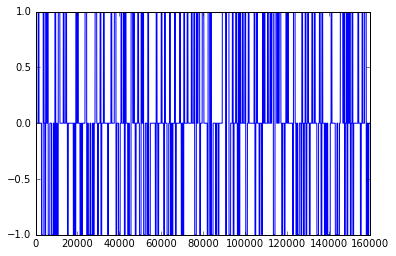

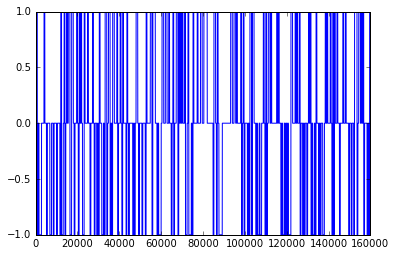

In [19]:
plt.plot(data['experiment_targets'][0,:])
plt.show()

plt.plot(data['experiment_targets'][1,:])
plt.show()

In [20]:
esn = MyESN()
esn.input_multiplier=10
esn.spectral_radius = 0.8
esn.create_esn()
esn.trial_length = trial_length
esn.trials = experiment_classes/rotation_step

esn.experiment_classes = data['experiment_classes']
esn.experiment_targets = data['experiment_targets'] 

esn.experiment_data = data['experiment_inputs']
esn.trainlen = data['experiment_inputs'].shape[1] /2
esn.future =  data['experiment_inputs'].shape[1] /2

esn.fit()
esn.predict()
#esn.analyse_results()

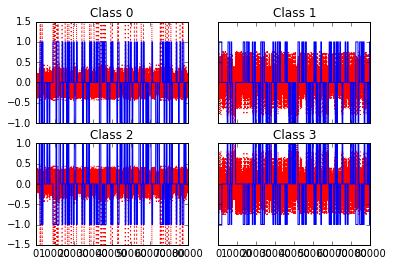

In [21]:
# row and column sharing
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
axs = [ax1,ax2,ax3,ax4]
for k in [0,1,2,3]:
    axs[k].plot(esn.prediction[100:,k],':r')
    axs[k].plot(esn.experiment_targets.T[esn.future+100:,k],'b')
    axs[k].set_title('Class %s' % k)
plt.savefig('OutputClasses.png')
plt.show()

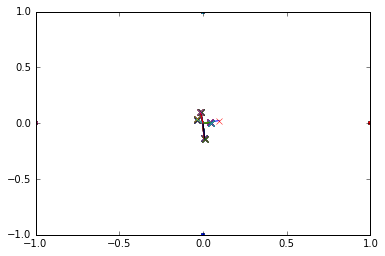

In [22]:
# for every trial
    # extract result slice
    # compute mean 
    # comoute angle

    
pre_trials = esn.trials[len(esn.trials)/2:] * rotation_step
output_data = {d:[] for  d in pre_trials}
output_angle = {d:[] for  d in pre_trials}

output_angle_rad = {d:[] for  d in pre_trials}
output_angle_d = {d:[] for  d in pre_trials}

input_angle = {d:[] for  d in pre_trials}

# A hack to  make sure the input angle is correctly transfomed
input_transform = {}

cols = ['x','o','^','v','.','*','+','x']



for i, trial in enumerate(pre_trials):
    tdata = esn.prediction[i*esn.trial_length:i*esn.trial_length+esn.trial_length,:]
    mean_xy = np.mean(tdata,axis=0)[0:2]
    
    target_xy = np.mean(esn.experiment_targets.T[esn.future+(i*esn.trial_length):esn.future+(i*esn.trial_length+esn.trial_length),:][:,0:2],axis=0)

    plt.plot([0,mean_xy[0]],[0,mean_xy[1]])
    
    
    
    plt.plot(target_xy[0],target_xy[1],'.')
    plt.plot(mean_xy[0],mean_xy[1],'x') 
    
    assert not math.isnan(mean_xy[1])
    output_data[trial].append(mean_xy)
    output_angle[trial].append((math.atan2(mean_xy[1],mean_xy[0])*(180/math.pi))) 

    input_angle[trial].append(np.mod((math.atan2(target_xy[1],target_xy[0])*(180/math.pi)),360)) 
    input_transform[esn.experiment_classes[trial]] = np.mod((math.atan2(target_xy[1],target_xy[0])*(180/math.pi)),360)
    
    output_angle_rad[trial].append(math.atan2(mean_xy[1],mean_xy[0])) 
    
    
    output_angle_d[trial].append(math.sqrt(mean_xy[0]*mean_xy[0] + mean_xy[1]*mean_xy[1]))
    
for d in output_data:
    output_data[d] = np.array(output_data[d])
plt.show()

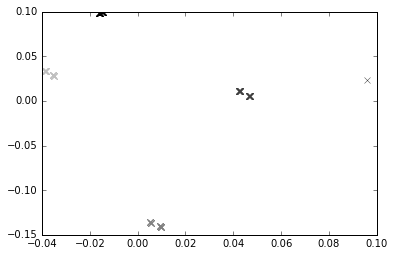

In [23]:
for d in output_data:
    plt.plot(output_data[d][:,0],output_data[d][:,1],'x', c = (d/360.0,d/360.0,d/360.0))


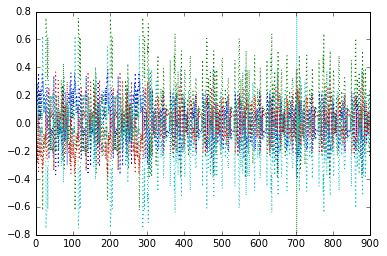

In [24]:
for k in [0,1,2,3]:
    plt.plot(esn.prediction[100:1000,k],':')


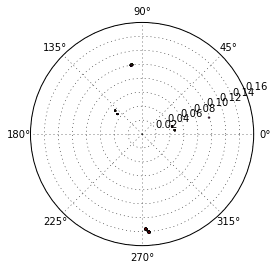

In [25]:
import numpy as np
import matplotlib.pyplot as plt



# Fixing random state for reproducibility
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
for d in output_angle_rad:
   
    # Compute areas and colors
    N = len(np.array(output_angle_rad[d]))
    r = np.array(output_angle_d[d])
    theta = np.array(output_angle_rad[d])
    area = 200 * r**2
    colors = theta

    c = ax.scatter(theta, r, c=colors, s=area, cmap='hsv', alpha=0.75)
plt.show()
    

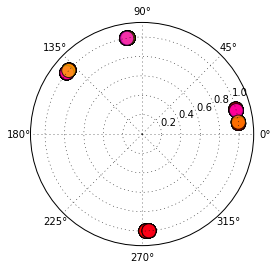

In [26]:
import numpy as np
import matplotlib.pyplot as plt



# Fixing random state for reproducibility
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
for d in output_angle_rad:
   
    # Compute areas and colors
    N = len(np.array(output_angle_rad[d]))
    r = np.ones(np.array(output_angle_rad[d]).shape)
    theta = np.array(output_angle_rad[d])
    area = 200 * r**2
    colors = theta

    c = ax.scatter(theta, r, c=colors, s=area, cmap='hsv', alpha=0.75)
plt.show()
    

In [27]:
np.array(output_angle_rad[d])    

array([2.42263656, 2.45739481, 2.45739481, 2.46038922, 2.42263656,
       2.42263656, 2.45739481, 2.45739481, 2.46038922, 2.45739481,
       2.42263656, 2.45739481, 2.45739481, 2.46038922, 2.45739481,
       2.42722591, 2.42722591, 2.45739481, 2.46038922, 2.42722591,
       2.42722591, 2.42263656, 2.42263656, 2.42263656, 2.46038922,
       2.42722591, 2.42722591, 2.45739481, 2.42263656, 2.42263656,
       2.46038922, 2.42722591, 2.42722591, 2.42263656, 2.42263656,
       2.46038922, 2.46038922, 2.42263656, 2.46038922, 2.42263656,
       2.46038922, 2.45739481, 2.45739481, 2.45739481, 2.45739481,
       2.42263656, 2.45739481, 2.42722591])

In [28]:
a = np.array([(d, np.mean(output_angle[d]) ) for d in output_angle])

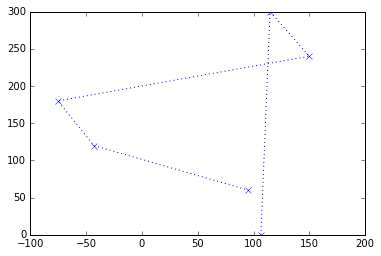

In [91]:
plt.plot(a[:,1],a[:,0],':x')

In [66]:
performance = []
ia = []
pr = []
# for every rotation in output_angle
for r in output_angle:
    for t in output_angle[r]:
        delta = abs(rotations - t)
        performance.append(int(input_angle[r][0]) == rotations[list(delta).index(min(delta))])
        ia.append(np.floor(input_angle[r][0]))
        pr.append(rotations[list(delta).index(min(delta))])
        
        if  int(input_angle[r][0]) != rotations[list(delta).index(min(delta))]:
            print r
            print delta
            print np.floor(input_angle[r][0])
            #break
        

#performance = sum(performance)/len(performance)

180
[ 66.50176348 156.50176348 246.50176348 336.50176348]
270.0
180
[ 87.96955566 177.96955566 267.96955566 357.96955566]
270.0
180
[ 86.40532399 176.40532399 266.40532399 356.40532399]
270.0
180
[ 87.96955566 177.96955566 267.96955566 357.96955566]
270.0
180
[ 87.96955566 177.96955566 267.96955566 357.96955566]
270.0
180
[ 87.96955566 177.96955566 267.96955566 357.96955566]
270.0
180
[ 87.96955566 177.96955566 267.96955566 357.96955566]
270.0
180
[ 87.96955566 177.96955566 267.96955566 357.96955566]
270.0
180
[ 87.96955566 177.96955566 267.96955566 357.96955566]
270.0
180
[ 86.40532399 176.40532399 266.40532399 356.40532399]
270.0
180
[ 87.96955566 177.96955566 267.96955566 357.96955566]
270.0
180
[ 87.96955566 177.96955566 267.96955566 357.96955566]
270.0
180
[ 87.96955566 177.96955566 267.96955566 357.96955566]
270.0
180
[ 86.40532399 176.40532399 266.40532399 356.40532399]
270.0
180
[ 86.21998189 176.21998189 266.21998189 356.21998189]
270.0
180
[ 86.40532399 176.40532399 266.40532

In [67]:
performance

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,

In [68]:
ds = esn.experiment_targets[0:2,:].T
a = []
for i in np.arange(ds.shape[0]):
    a.append(math.atan2(ds[i,1],ds[i,0])*(180/np.pi))
    

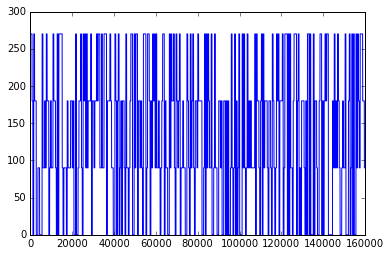

In [69]:
plt.plot(np.mod(a,360))

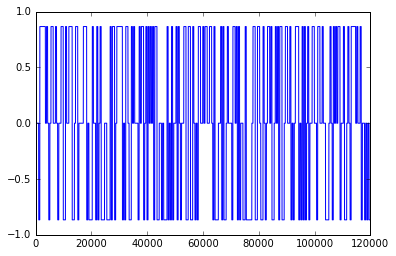

In [100]:
plt.plot(esn.experiment_targets.T[esn.future+100:,0],'b')

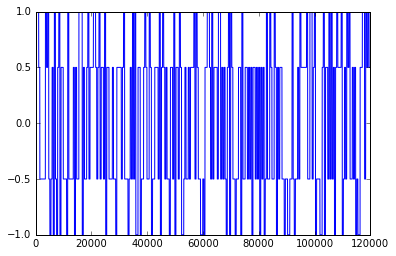

In [101]:
plt.plot(esn.experiment_targets.T[esn.future+100:,1],'b')

In [ ]:
# THURSDAY: Check inputs for 